In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datacq
import numpy as np
import math
import scipy
from IPython.display import display, HTML
import statsmodels.api as sm
import sklearn.metrics
from helper import sceptic_mean
import os.path


In [2]:
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)
stationCode = "BETR222" #"BETN063" #"BETN043" #"BETR501"

target = "PM10"
pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]
# Read era5 parameters from file
with open('data/era5_params.txt', 'r') as f:
    era5_params = [p.strip() for p in f.readlines()]

# Remove unwanted parameters
era5_params.remove('skin_reservoir_content')
era5_params.remove('evaporation_from_the_top_of_canopy')
era5_params.remove('evaporation_from_open_water_surfaces_excluding_oceans')
era5_params.remove('evaporation_from_vegetation_transpiration')
era5_params.remove('forecast_albedo') 
era5_params.remove('leaf_area_index_high_vegetation')
era5_params.remove('leaf_area_index_low_vegetation')
era5_params.remove('snow_evaporation')

df_full = datacq.getdf(years, stationCode, era5_params, pollutants)

Station: BETR222
Retrieving pollution data...
Retrieving ERA5 data...


2022-05-13 11:39:50,346 INFO Welcome to the CDS
2022-05-13 11:39:50,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-05-13 11:39:50,421 INFO Request is queued
2022-05-13 15:00:40,076 INFO Request is running
2022-05-13 15:54:47,311 INFO Request is queued
2022-05-13 17:08:57,321 INFO Request is running
2022-05-13 20:09:27,668 INFO Request is completed
2022-05-13 20:09:27,699 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data8/adaptor.mars.internal-1652454461.7805078-1679-4-5f8a43ac-60d6-4936-8d31-cf5ef82ba851.grib to data/temp.grib (16.1M)
2022-05-13 20:09:33,133 INFO Download rate 3M/s     
2022-05-13 20:09:33,357 WARNING Ignoring index file 'data/temp.grib.923a8.idx' older than GRIB file


2022-05-13 20:12:31,535 INFO Welcome to the CDS
2022-05-13 20:12:31,537 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-05-13 20:12:31,604 INFO Request is queued
2022-05-14 01:24:27,722 INFO Request is running
2022-05-14 04:22:51,115 INFO Request is completed
2022-05-14 04:22:51,117 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/adaptor.mars.internal-1652484178.5920494-11543-18-85284e06-ec86-4acd-95d9-c51a253a55d0.grib to data/temp.grib (8M)
2022-05-14 04:22:53,787 INFO Download rate 3M/s     
2022-05-14 04:22:53,855 WARNING Ignoring index file 'data/temp.grib.923a8.idx' older than GRIB file


2022-05-14 04:24:56,667 INFO Welcome to the CDS
2022-05-14 04:24:56,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-05-14 04:24:56,845 INFO Request is queued
2022-05-14 06:55:39,505 INFO Request is running
2022-05-14 10:00:02,843 INFO Request is completed
2022-05-14 10:00:02,844 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data5/adaptor.mars.internal-1652504070.836973-21954-1-28eb4912-c59b-485b-81aa-ec80cbffce8f.grib to data/temp.grib (8M)
2022-05-14 10:00:05,467 INFO Download rate 3.1M/s   
2022-05-14 10:00:05,591 WARNING Ignoring index file 'data/temp.grib.923a8.idx' older than GRIB file


In [4]:
print("Missing values")
tot = len(df_full)
for var in df_full.columns:
    nanrate = df_full[var].isna().sum()/tot
    if nanrate>0:
        print(f'{var}:\t  {nanrate:.2f}')
df_full.drop('stl1', axis=1, inplace=True)

Missing values
SO2:	  0.04
NO2:	  0.03
CO:	  0.03
O3:	  0.05
PM2.5:	  0.01
PM10:	  0.01
stl1:	  0.10


In [28]:
pd.options.display.float_format = '{:,.2f}'.format
nbHours=9
pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]
pollutants = [pol for pol in pollutants if pol in df_full.columns]

morningHours = df_full.loc[df_full.index.hour<= nbHours-1, pollutants]
morning_polutants = [f'{pl}_day0_{nbHours}h' for pl in pollutants]

df_daily = df_full.resample('D').apply(sceptic_mean, max_nan=4) #Get daily means
df_daily['PM10_day0'] = df_daily['PM10'].shift(1)
df_daily[morning_polutants] = morningHours.resample('D').apply(sceptic_mean, max_nan=2).shift(1)
df_daily = df_daily.iloc[1: , :]

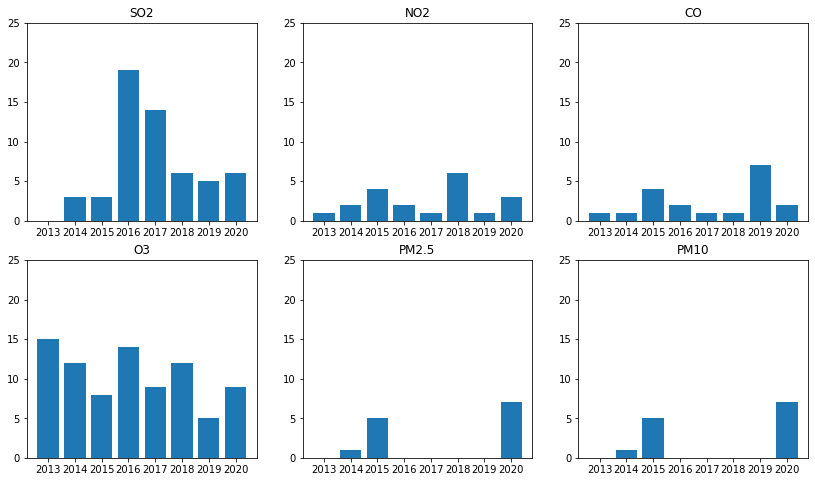

In [29]:
fig = plt.figure(figsize=(14, 8))
nancounts_per_year = df_daily.groupby(df_daily.index.year).apply(lambda x: x.isna().sum())
years = nancounts_per_year.index
plt.title('Number of missing values')
plot_id=0
for pol in pollutants:
    plot_id+=1
    ax = plt.subplot(2, 3, plot_id)
    ax.bar(x=years, height=nancounts_per_year[pol])
    plt.ylim(top=25)
    ax.set_xticks(years)
    plt.title(pol)
plt.show()

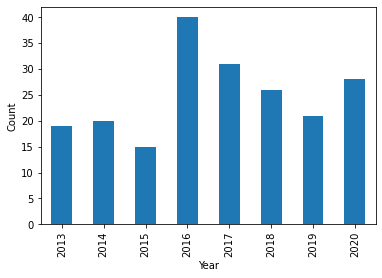

In [30]:
rows_with_nan = df_daily.isna().any(axis=1)
nanrows_per_year = rows_with_nan.groupby(rows_with_nan.index.year).sum()
nanrows_per_year.plot.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [31]:
df_daily_train = df_daily[df_daily.index.year<2019].copy()
df_daily_train.sort_index(inplace=True, ascending=True)
df_daily_train = df_daily_train.drop([var for var in pollutants if var!="PM10"], axis=1)
df_daily_train["PM10_log"] = np.log(1+df_daily_train["PM10"])
df_daily_train.dropna(inplace=True)
df_daily_train.head()

PM10  mcc  hcc    blh  swvl4  swvl3  swvl2   tp  \
DatetimeBegin                                                                
2013-01-02 00:00:00+01:00 19.15 0.47 0.19 437.33   0.38   0.41   0.41 0.00   
2013-01-03 00:00:00+01:00 18.81 0.30 0.38 439.12   0.38   0.41   0.41 0.00   
2013-01-04 00:00:00+01:00 17.60 0.03 0.56 488.67   0.38   0.41   0.40 0.00   
2013-01-05 00:00:00+01:00 23.83 0.00 0.12 345.01   0.38   0.41   0.39 0.00   
2013-01-06 00:00:00+01:00 30.06 0.02 0.85 360.67   0.38   0.41   0.39 0.00   

                                  strd      ssrd  ...  w_dir  DoW  PM10_day0  \
DatetimeBegin                                     ...                          
2013-01-02 00:00:00+01:00 1,090,395.34 95,530.31  ...   0.57 2.00       6.53   
2013-01-03 00:00:00+01:00 1,271,024.96 36,489.16  ...   0.43 3.00      19.15   
2013-01-04 00:00:00+01:00 1,260,606.00 46,432.21  ...   0.09 4.00      18.81   
2013-01-05 00:00:00+01:00 1,237,320.88 43,857.52  ...   0.05 5.00      17.60   
2013-01-06 00:00:00+01:00 1,237,107.29 60,228.30  ...   0.01 6.00      23.83   

                           SO2_day0_9h  NO2_day0_9h  CO_day0_9h  O3_day0_9h  \
DatetimeBegin                                                                 
2013-01-02 00:00:00+01:00         0.88         1.94      100.41       62.81   
2013-01-03 00:00:00+01:00         1.00        16.06      132.91       37.67   
2013-01-04 00:00:00+01:00         1.00         7.61      114.28       46.56   
2013-01-05 00:00:00+01:00         1.00         5.81       96.35       46.75   
2013-01-06 00:00:00+01:00         0.00        16.11      131.52       30.11   

                           PM2.5_day0_9h  PM10_day0_9h  PM10_log  
DatetimeBegin                                                     
2013-01-02 00:00:00+01:00           0.04          0.45      3.00  
2013-01-03 00:00:00+01:00           9.80         13.66      2.99  
2013-01-04 00:00:00+01:00           5.66          7.72      2.92  
2013-01-05 00:00:00+01:00          14.04         18.05      3.21  
2013-01-06 00:00:00+01:00          27.42         32.66      3.44  

[5 rows x 39 columns]

In [77]:
x_vars = list(df_daily_train.columns)
x_vars.remove("PM10")
x_vars.remove("PM10_day0")
x_vars.remove("PM10_log")

metrics = pd.DataFrame(index=x_vars)
for var in x_vars:
    sc_X = StandardScaler()
    X_normal = sc_X.fit_transform(df_daily_train[var].values.reshape(-1, 1)).flatten()
    #metrics.loc[var,"R_log"] = abs(np.corrcoef(df_daily_train["PM10_log"], X_normal)[0,1])
    metrics.loc[var,"PCC"] = abs(np.corrcoef(df_daily_train["PM10"], X_normal)[0,1])
    metrics.loc[var,"Spearman"] = abs(scipy.stats.spearmanr(df_daily_train["PM10"], X_normal).correlation)

metrics =metrics.sort_values(by='PCC', ascending=False)
newIndex = metrics.index.tolist()
for i,var in enumerate(metrics.index):
    if var in namesDict:
        newIndex[i] = namesDict[var]
metrics.index = newIndex
metrics

PCC  Spearman
boundary_layer_height               0.56      0.62
w_speed                             0.55      0.63
NO2_day0_9h                         0.55      0.57
PM10_day0_9h                        0.55      0.56
PM2.5_day0_9h                       0.54      0.53
CO_day0_9h                          0.36      0.27
O3_day0_9h                          0.36      0.38
w_dir                               0.33      0.31
medium_cloud_cover                  0.32      0.40
surface_pressure                    0.31      0.37
surface_sensible_heat_flux          0.31      0.34
total_precipitation                 0.30      0.45
high_cloud_cover                    0.19      0.20
surface_thermal_radiation_downwards 0.18      0.12
surface_net_thermal_radiation       0.17      0.22
surface_runoff                      0.17      0.48
sub_surface_runoff                  0.16      0.11
volumetric_soil_water_layer_4       0.15      0.12
soil_temperature_level_4            0.14      0.09
2m_dewpoint_temperature             0.14      0.05
surface_solar_radiation_downwards   0.13      0.20
surface_net_solar_radiation         0.13      0.20
soil_temperature_level_3            0.13      0.05
2m_temperature                      0.11      0.03
soil_temperature_level_2            0.10      0.04
runoff                              0.10      0.05
potential_evaporation               0.10      0.08
skin_temperature                    0.09      0.01
snow_evaporation                    0.09      0.17
evaporation_from_bare_soil          0.08      0.14
volumetric_soil_water_layer_2       0.08      0.19
total_evaporation                   0.07      0.07
surface_latent_heat_flux            0.07      0.07
volumetric_soil_water_layer_3       0.06      0.01
SO2_day0_9h                         0.02      0.00
DoW                                 0.01      0.01

In [78]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

X_full = df_daily_train[x_vars+["PM10_day0"]]
y = df_daily_train["PM10"]


svr_lin_full = Pipeline([('scaler',  StandardScaler()),
            ('svr', SVR())])
tscv = TimeSeriesSplit(n_splits=5)
gsc = GridSearchCV(
    svr_lin_full,
    param_grid={
        'svr__kernel': ['linear'],
        'svr__C': [0.1, 1, 10, 100],
        'svr__epsilon': [0.0001, 0.0005]},

    cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

grid_result = gsc.fit(X_full[x_vars], y)
svr_lin_full = grid_result.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [79]:
coefs = svr_lin_full['svr'].coef_[0]

for i,var in enumerate(x_vars):
    var_name = namesDict[var] if var in namesDict else var
    metrics.loc[var_name,"SVR coef"] = abs(coefs[i])

metrics =metrics.sort_values(by='SVR coef', ascending=False)
metrics

PCC  Spearman  SVR coef
boundary_layer_height               0.56      0.62      3.07
w_dir                               0.33      0.31      2.07
w_speed                             0.55      0.63      1.83
NO2_day0_9h                         0.55      0.57      1.73
PM10_day0_9h                        0.55      0.56      1.62
total_evaporation                   0.07      0.07      1.55
volumetric_soil_water_layer_2       0.08      0.19      1.16
potential_evaporation               0.10      0.08      1.07
medium_cloud_cover                  0.32      0.40      1.05
surface_sensible_heat_flux          0.31      0.34      0.98
volumetric_soil_water_layer_3       0.06      0.01      0.91
total_precipitation                 0.30      0.45      0.82
evaporation_from_bare_soil          0.08      0.14      0.81
surface_thermal_radiation_downwards 0.18      0.12      0.77
soil_temperature_level_2            0.10      0.04      0.71
snow_evaporation                    0.09      0.17      0.66
volumetric_soil_water_layer_4       0.15      0.12      0.64
soil_temperature_level_3            0.13      0.05      0.58
PM2.5_day0_9h                       0.54      0.53      0.56
CO_day0_9h                          0.36      0.27      0.50
runoff                              0.10      0.05      0.50
surface_net_solar_radiation         0.13      0.20      0.50
sub_surface_runoff                  0.16      0.11      0.49
surface_solar_radiation_downwards   0.13      0.20      0.37
O3_day0_9h                          0.36      0.38      0.25
DoW                                 0.01      0.01      0.22
surface_latent_heat_flux            0.07      0.07      0.18
skin_temperature                    0.09      0.01      0.15
surface_pressure                    0.31      0.37      0.15
surface_net_thermal_radiation       0.17      0.22      0.14
surface_runoff                      0.17      0.48      0.13
2m_temperature                      0.11      0.03      0.10
SO2_day0_9h                         0.02      0.00      0.09
soil_temperature_level_4            0.14      0.09      0.07
high_cloud_cover                    0.19      0.20      0.01
2m_dewpoint_temperature             0.14      0.05      0.01

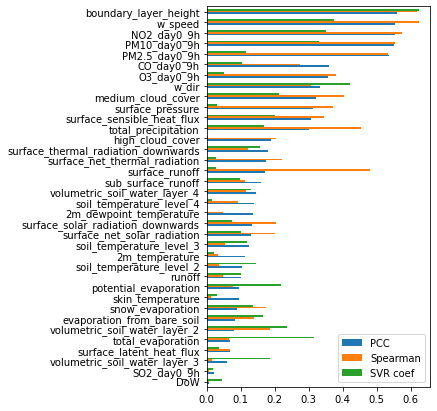

In [80]:
scale_svr = metrics['Spearman'].max()/metrics['SVR coef'].max()
metrics_scaled = metrics.copy()
metrics_scaled['SVR coef'] *= scale_svr
sortBy = 'PCC'
metrics_scaled.sort_values(by=sortBy, ascending=True).plot.barh(figsize=(4, 7))
plt.savefig(os.path.join("..","figures",f"metrics_by_{sortBy}.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)
plt.show()

In [81]:
top10s = pd.DataFrame()
for m in metrics.columns:
    top10s[m] = metrics[m].nlargest(10).index


with open(os.path.join('..','latex','tables', 'scores.txt'), "w") as text_file:
    text_file.write(top10s.to_latex(index=False))
top10s

PCC               Spearman                       SVR coef
0  boundary_layer_height                w_speed          boundary_layer_height
1                w_speed  boundary_layer_height                          w_dir
2            NO2_day0_9h            NO2_day0_9h                        w_speed
3           PM10_day0_9h           PM10_day0_9h                    NO2_day0_9h
4          PM2.5_day0_9h          PM2.5_day0_9h                   PM10_day0_9h
5             CO_day0_9h         surface_runoff              total_evaporation
6             O3_day0_9h    total_precipitation  volumetric_soil_water_layer_2
7                  w_dir     medium_cloud_cover          potential_evaporation
8     medium_cloud_cover             O3_day0_9h             medium_cloud_cover
9       surface_pressure       surface_pressure     surface_sensible_heat_flux

In [82]:
metrics_rank = pd.DataFrame()
for m in metrics.columns:
    metrics_rank[f'{m}_rank'] = metrics[m].rank(ascending=False)
metrics_rank['average'] = metrics_rank.mean(axis=1)

with open(os.path.join('..','latex','tables', 'top10rank.txt'), "w") as text_file:
    text_file.write(metrics_rank['average'].nsmallest(10).to_latex(header=False))
metrics_rank.sort_values(by='average')

PCC_rank  Spearman_rank  SVR coef_rank  \
boundary_layer_height                    1.00           2.00           1.00   
w_speed                                  2.00           1.00           3.00   
NO2_day0_9h                              3.00           3.00           4.00   
PM10_day0_9h                             4.00           4.00           5.00   
w_dir                                    8.00          12.00           2.00   
medium_cloud_cover                       9.00           8.00           9.00   
PM2.5_day0_9h                            5.00           5.00          19.00   
total_precipitation                     12.00           7.00          12.00   
surface_sensible_heat_flux              11.00          11.00          10.00   
CO_day0_9h                               6.00          13.00          20.00   
O3_day0_9h                               7.00           9.00          25.00   
surface_thermal_radiation_downwards     14.00          21.00          14.00   
surface_pressure                        10.00          10.00          29.00   
surface_runoff                          16.00           6.00          31.00   
volumetric_soil_water_layer_2           31.00          18.00           7.00   
volumetric_soil_water_layer_4           18.00          22.00          17.00   
surface_net_thermal_radiation           15.00          14.00          30.00   
potential_evaporation                   27.00          25.00           8.00   
surface_solar_radiation_downwards       21.00          15.00          24.00   
surface_net_solar_radiation             22.00          17.00          22.00   
sub_surface_runoff                      17.00          23.00          23.00   
evaporation_from_bare_soil              30.00          20.00          13.00   
snow_evaporation                        29.00          19.00          16.00   
high_cloud_cover                        13.00          16.00          35.00   
total_evaporation                       32.00          27.00           6.00   
soil_temperature_level_3                23.00          28.00          18.00   
soil_temperature_level_2                25.00          31.00          15.00   
runoff                                  26.00          29.00          21.00   
soil_temperature_level_4                19.00          24.00          34.00   
volumetric_soil_water_layer_3           34.00          33.00          11.00   
surface_latent_heat_flux                33.00          26.00          27.00   
2m_dewpoint_temperature                 20.00          30.00          36.00   
2m_temperature                          24.00          32.00          32.00   
skin_temperature                        28.00          34.00          28.00   
DoW                                     36.00          35.00          26.00   
SO2_day0_9h                             35.00          36.00          33.00   

                                     average  
boundary_layer_height                   1.33  
w_speed                                 2.00  
NO2_day0_9h                             3.33  
PM10_day0_9h                            4.33  
w_dir                                   7.33  
medium_cloud_cover                      8.67  
PM2.5_day0_9h                           9.67  
total_precipitation                    10.33  
surface_sensible_heat_flux             10.67  
CO_day0_9h                             13.00  
O3_day0_9h                             13.67  
surface_thermal_radiation_downwards    16.33  
surface_pressure                       16.33  
surface_runoff                         17.67  
volumetric_soil_water_layer_2          18.67  
volumetric_soil_water_layer_4          19.00  
surface_net_thermal_radiation          19.67  
potential_evaporation                  20.00  
surface_solar_radiation_downwards      20.00  
surface_net_solar_radiation            20.33  
sub_surface_runoff                     21.00  
evaporation_from_bare_soil             21.00  
snow_evaporation                

In [83]:
bestVars_long = list(metrics_rank.sum(axis=1).nsmallest(10).index.values)
x_vars_best = []
for v in bestVars_long:
    if v in namesDict.values(): 
        x_vars_best.append(list(namesDict.keys())[list(namesDict.values()).index(v)])
    else:
        x_vars_best.append(v)
x_vars_best_DoW = x_vars_best+['DoW']
x_vars_best_no_PM25 = [v for v in x_vars_best if v!='PM2.5_day0_9h']

X_train = X_full[X_full.index.year<2018]
y_train = y[y.index.year<2018]
X_test = X_full[X_full.index.year==2018]
y_test = y[y.index.year==2018]


In [84]:
pipe_SVR = Pipeline([('scaler',  StandardScaler()),
            ('svr', SVR())])
tscv = TimeSeriesSplit(n_splits=5)
p_grid = {
        'svr__kernel': ['rbf'],
        'svr__C': [0.1, 1, 10, 100],
        'svr__gamma': [1e-4, 1e-3, 0.01, 0.1, 1, 10],
        'svr__epsilon': [0.0001, 0.0005]}
gsc = GridSearchCV(
    pipe_SVR,
    param_grid=p_grid,
    cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

grid_result__rbf_best = gsc.fit(X_train[x_vars_best], y_train)
svr_rbf_best = grid_result__rbf_best.best_estimator_

grid_result__rbf_full = gsc.fit(X_train[x_vars], y_train)
svr_rbf_full = grid_result__rbf_full.best_estimator_
#grid_result_best_DoW = gsc.fit(X_train[x_vars_best_DoW], y_train)
#best_SVR_rbf_DoW = grid_result_best_DoW.best_estimator_
#grid_result_best_no_PM25 = gsc.fit(X_train[x_vars_best_no_PM25], y_train)
#best_SVR_rbf_no_PM25 = grid_result_best_no_PM25.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


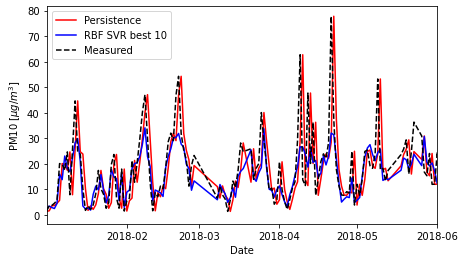

In [85]:
import datetime
short = True
pers = True
svr = True
y_pred_persistence9 = X_test['PM10_day0_9h']
y_pred_persistence = X_test['PM10_day0']
y_pred_svr_rbf_best = svr_rbf_best.predict(X_test[x_vars_best])
y_pred_svr_rbf_full = svr_rbf_full.predict(X_test[x_vars])
#y_pred_svr_rbf_best_DoW = best_SVR_rbf_DoW.predict(X_test[x_vars_best_DoW])
#y_pred_svr_rbf_best_no_PM25 = best_SVR_rbf_no_PM25.predict(X_test[x_vars_best_no_PM25])
y_pred_svr_lin_full = svr_lin_full.predict(X_test[x_vars])
if pers and svr:
    plt.figure(figsize=(7,4))
else:
    plt.figure(figsize=(10,4))
if pers:
    plt.plot(y_test.index, y_pred_persistence, 'r', label='Persistence')
if svr:
    plt.plot(y_test.index, y_pred_svr_rbf_best, 'b', label='RBF SVR best 10')
plt.plot(y_test.index, y_test, 'k--', alpha=1, label='Measured')
ax = plt.gca()
if short:
    ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
#plt.plot(y_test.index, y_pred_svr_lin_full, 'y')
plt.legend()
plt.ylabel(r"PM10 [$\mu g/m^3$]")
plt.xlabel('Date')
plt.savefig(os.path.join("..","figures",f"test{'_persistence' if pers else ''}"
                                        f"{'_SVR' if svr else ''}_{'short' if short else 'full'}.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=300)
plt.show()

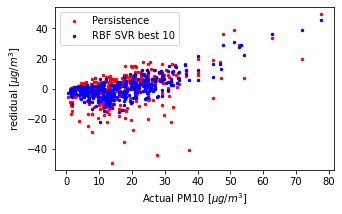

In [86]:
residual_svr_rbf_best = y_test-y_pred_svr_rbf_best
residual_persistence = y_test-y_pred_persistence
marker_size = 6
plt.figure(figsize=(5,3))
plt.scatter(y_test, residual_persistence, c='r', s=marker_size, label='Persistence')
plt.scatter(y_test, residual_svr_rbf_best, c='b', s=marker_size, label='RBF SVR best 10')
plt.ylabel('redidual [$\mu g/m^3$]')
plt.xlabel('Actual PM10 [$\mu g/m^3$]')
plt.legend()
plt.savefig(os.path.join('..','figures','residuals_svr'),
            facecolor='white', edgecolor='none', bbox_inches='tight', dpi=300)
plt.show()

In [75]:
nvar_full = X_test.shape[1]
results_df = pd.DataFrame()
predictions = {'Persistence': y_pred_persistence,
                f'Linear SVR Full ({nvar_full})':y_pred_svr_lin_full,
                f'RBF SVR Full ({nvar_full})':y_pred_svr_rbf_full,
                'RBF SVR best 10': y_pred_svr_rbf_best}
                #'svr_rbf_best_DoW': y_pred_svr_rbf_best_DoW,
                #'svr_rbf_bestno_PM25': y_pred_svr_rbf_best_no_PM25}
metric_functions = {'RMSE': lambda y_true, y_pred: sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False),
                    'sMAPE': smape,
                    'MAE': sklearn.metrics.mean_absolute_error}
for model,y_pred in predictions.items():
    for metric,m_f in metric_functions.items():
        results_df.loc[model,metric] = m_f(y_test,y_pred)


scale = np.mean(np.abs(y_test-y_pred_persistence))
for m,y_pred in predictions.items():
    results_df.loc[m, 'MASE'] = np.mean(np.abs(y_test-y_pred))/scale
with open(os.path.join('..','latex','tables', 'SVR_results.txt'), "w") as text_file:
    text_file.write(results_df.to_latex())
results_df

RMSE  sMAPE  MAE  MASE
Persistence          10.71  46.59 7.47  1.00
Linear SVR Full (37)  8.00  37.87 5.45  0.73
RBF SVR Full (37)     7.28  31.35 4.88  0.65
RBF SVR best 10       7.81  32.56 5.29  0.71

In [18]:
correlations = pd.DataFrame()
for pol in pollutants:
    print(pol)
    corr_temp = []
    for h in range(1,25):
        avg_pol = np.log(1+df_full.loc[df_full.index.hour<= h-1, pol])
        df_temp = pd.DataFrame()
        df_temp['pol_morning'] = avg_pol.resample('D').mean().shift(1)
        df_temp['PM10_log'] = df_daily_train["PM10_log"]
        df_temp.dropna(inplace=True)
        #corr_temp.append(np.corrcoef(df_temp["PM10_log"], np.log(df_temp["pol_morning"]))[0,1]**2)
        corr_temp.append(scipy.stats.spearmanr(df_temp["PM10_log"], df_temp["pol_morning"]).correlation**2)
    correlations[pol] = corr_temp

SO2
NO2
CO
O3
PM2.5
PM10


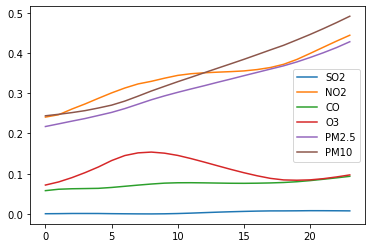

In [19]:
correlations.plot()

plt.show()